In [1]:
using QuantEcon, Optim, CairoMakie, LinearAlgebra, Dierckx

In [2]:
function create_model(;nk = 31)

    p = (;α = 0.33, # Capital share
        β = 0.9, # Discount factor
        δ = 0.1, # Dep rate
        A = 1.0, # TFP
        γ = 2.0, # Risk aversion
        θ = 3.0, # Grid expansion parameter
        η = 0.8, # Frisch elasticity
        ι = 2.0, # Labour weight
        kmin = 1e-2, # Lower bound of capital
        kmax = 2.0, # Upper bound of capital
        kgrid = zeros(Float64, nk), # initialise capital grid
        tol = 1e-6, # VFI tolerance
        maxiter = 10_000, # Maximum number of iterations
        print_skip = 25, # Print every print_skip iterations
        nk = nk) # Number of capital grid points

    # Create capital grid
    temp_grid = LinRange(0,1,nk)
    kgrid = p.kmin .+ (p.kmax - p.kmin) * temp_grid.^p.θ

    # Return new NamedTuple
    p = (;p..., kgrid = kgrid)

    return p
end

model = create_model(nk = 101)

(α = 0.33, β = 0.9, δ = 0.1, A = 1.0, γ = 2.0, θ = 3.0, η = 0.8, ι = 2.0, kmin = 0.01, kmax = 2.0, kgrid = [0.01, 0.01000199, 0.010015920000000001, 0.01005373, 0.01012736, 0.010248750000000001, 0.010429840000000001, 0.01068257, 0.01101888, 0.01145071  …  1.5096062900000002, 1.55958912, 1.61067043, 1.6628621599999998, 1.7161762499999997, 1.7706246399999999, 1.82621927, 1.8829720799999998, 1.9408950099999998, 2.0], tol = 1.0e-6, maxiter = 10000, print_skip = 25, nk = 101)

In [3]:
function u(c, p)
    (; γ) = p
    if γ == 1.0
        return log(c)
    else
        return (c^(1-γ)-1)/(1-γ)
    end
end

function v(l, p)
    (; η, ι) = p
    return ι*((l)^(1+η))/(1+η)
end

function resources(k, l, p)
    (; A, α, δ) = p
    return A*(k^α)*(l^(1-α))+(1-δ)*k
end

function interpV(grid, v)
    return Spline1D(grid, v, k=3, bc="extrapolate")
end

function prob(kgrid, i, x, interp_v, p)
    (; β) = p
    return -[u(resources(kgrid[i],x[2],p)-x[1], p) - v(x[2], p) + β*interp_v(x[1])][1,1]
end

function B!(Vnew, interp_v, pol_k, pol_l, kgrid, p)
    (; nk, β) = p
    lb = [resources(kgrid[1], 0.0, p), 0.1]
    for i in 1:nk
        ub = [resources(kgrid[i], 1.0, p), 1.0]
        obj(x) = prob(kgrid, i, x, interp_v, p)
        res = optimize(obj, lb, ub, [kgrid[i], 0.5])
        Vnew[i] = -res.minimum
        pol_k[i] = res.minimizer[1]
        pol_l[i] = res.minimizer[2]
    end
    return Vnew, pol_k, pol_l
end

B! (generic function with 1 method)

In [4]:
function solve(p)
    # Unpack parameters
    (; tol, maxiter, print_skip, nk, kgrid) = p

    # Initialise arrays
    V = zeros(Float64, nk)
    Vnew = zeros(Float64, nk)
    pol_k = zeros(Float64, nk)
    pol_l = ones(Float64, nk)

    # Pre-allocate interpolation
    interp_v = interpV(kgrid, V)

    # Run VFI
    error = tol + 1.0
    iter = 0
    println("Iterating...")
    while ((error > tol) && (iter < maxiter))
        if iter > 0
            interp_v = interpV(kgrid, V)
        end
        B!(Vnew, interp_v, pol_k, pol_l, kgrid, p)
        error = maximum(abs.(Vnew .- V)) 
        V .= Vnew
        if iter % print_skip == 0
            println("--------------------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------------------")
    println("Completed in $iter iterations")
    return V, pol_k, pol_l
end

@time begin
    v_out, pol_k_out, pol_l_out = solve(model)
end

Iterating...
--------------------------------
Iteration: 0, Error: 4.681993007383554
--------------------------------
Iteration: 25, Error: 0.08583388229858357
--------------------------------
Iteration: 50, Error: 0.006138449001202417
--------------------------------
Iteration: 75, Error: 0.0004406713036004817
--------------------------------
Iteration: 100, Error: 3.163570229247625e-5
--------------------------------
Iteration: 125, Error: 2.271120713714936e-6
--------------------------------
Completed in 134 iterations
  5.745453 seconds (17.77 M allocations: 975.351 MiB, 3.68% gc time, 68.83% compilation time)


([-21.03616866603735, -21.035610049256647, -21.031703406589155, -21.02113194958072, -21.00067959594497, -20.967341337174265, -20.918463789536176, -20.85189863886278, -20.766144120826418, -20.660447613347692  …  -9.149898429818263, -9.057955800289296, -8.96650739816005, -8.875548025608468, -8.785072752653603, -8.69507690421467, -8.605556021970859, -8.51650583697831, -8.427922273541814, -8.339801427678813], [0.057712437843269106, 0.05771867432870793, 0.05776231762837228, 0.05788067242795495, 0.058110720779605364, 0.058488800913517006, 0.059049469132393576, 0.05982418220757566, 0.06084229877261399, 0.062130778434154425  …  1.4828964793404094, 1.522834341650322, 1.5636156972582131, 1.6052524592808346, 1.6477581347822727, 1.69114404546688, 1.7354213213890048, 1.7806014504548273, 1.826695336430465, 1.8737170601789468], [0.9999999999329015, 0.9999999999327807, 0.9999999999319361, 0.9999999999296553, 0.9999999999252599, 0.9999999999181441, 0.9999999999078203, 0.9999999998939652, 0.999999999876

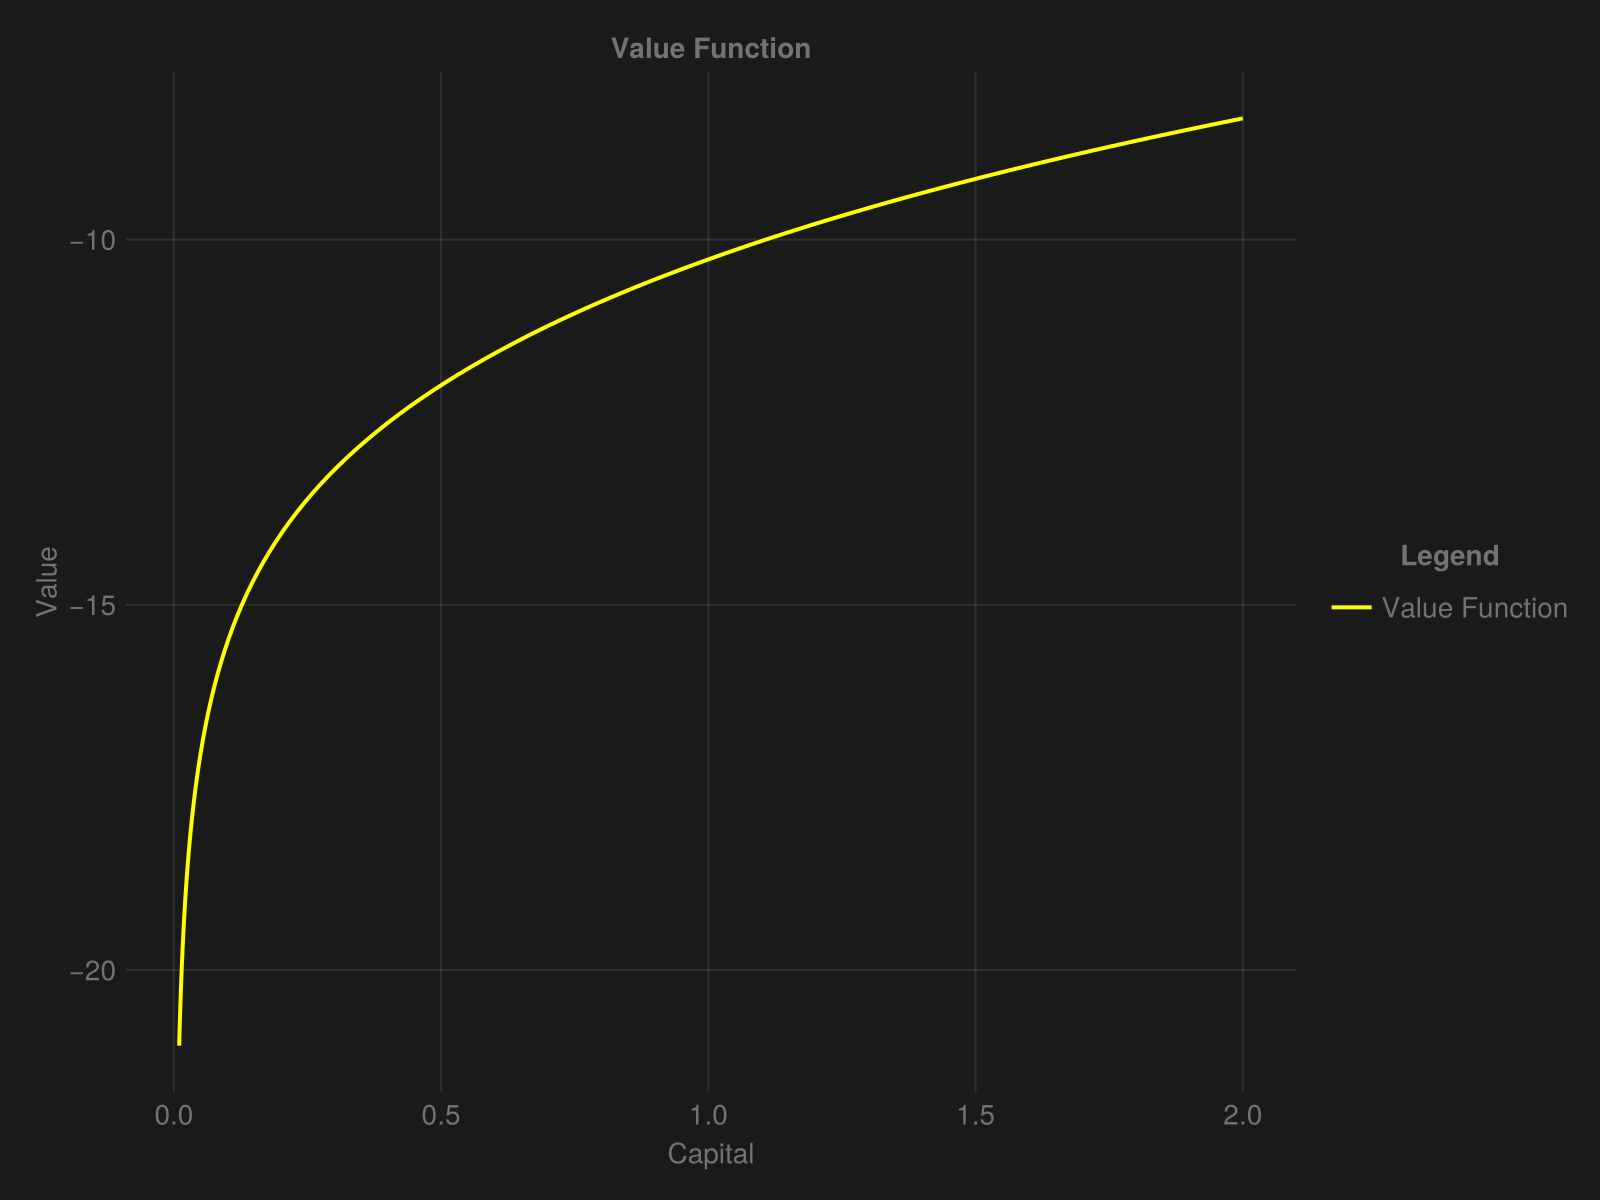

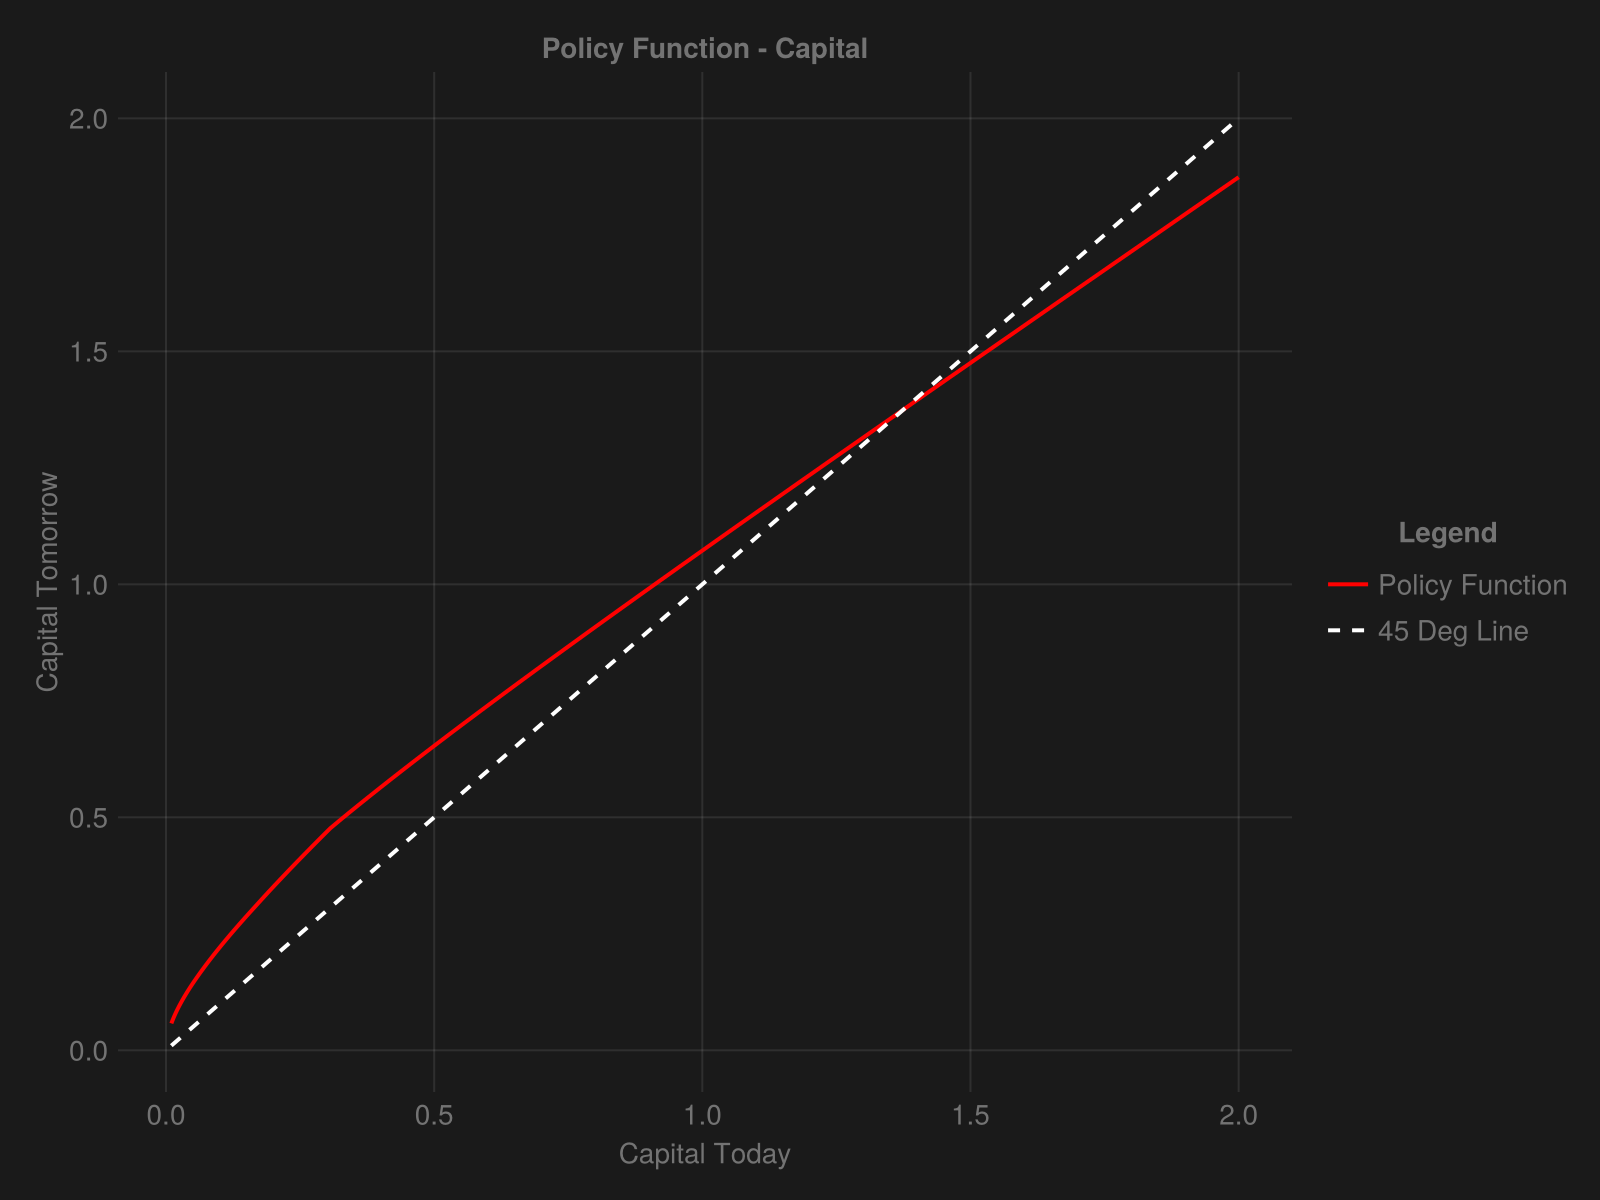

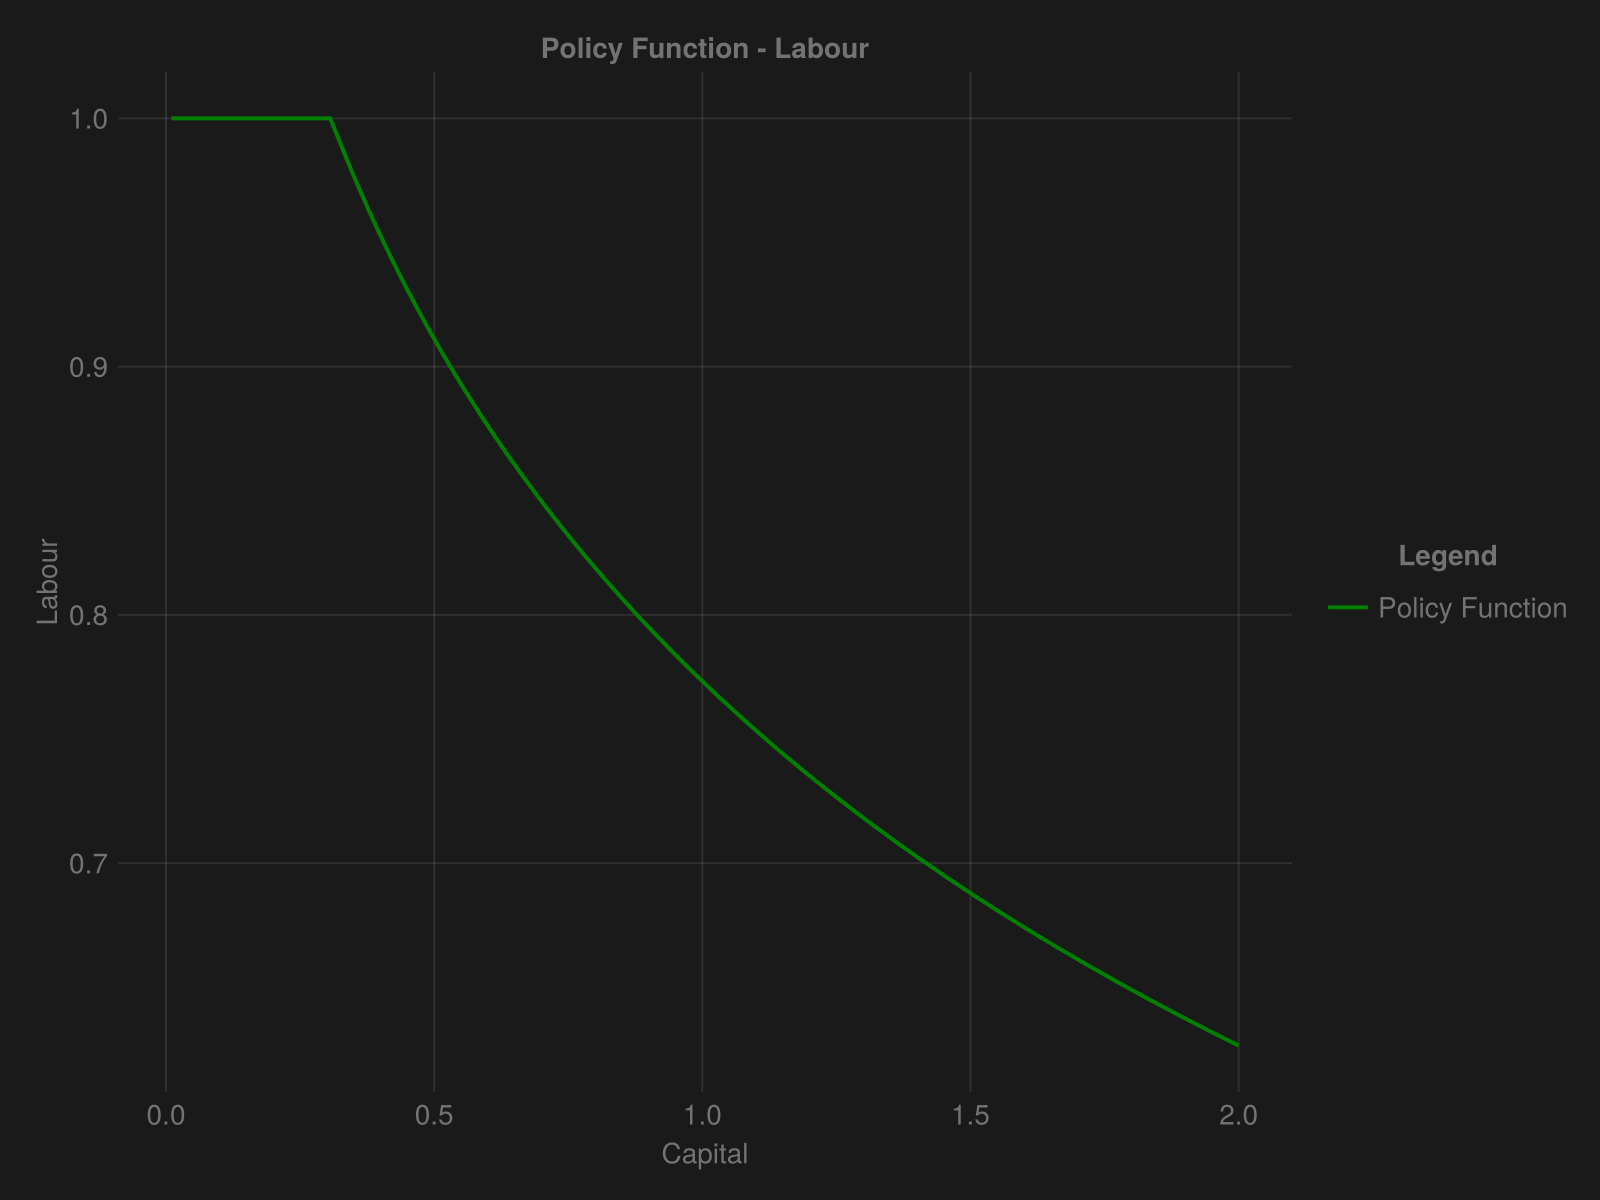

In [5]:
set_theme!(theme_dark())

figv = Figure(size = (800, 600))
axv = Axis(figv[1, 1], xlabel = "Capital", ylabel = "Value", title = "Value Function")
lines!(axv, model.kgrid, v_out, color = :yellow, linewidth = 2, label = "Value Function")
legend = Legend(figv[1, 2], axv, "Legend", orientation = :vertical)
display(figv)

figk = Figure(size = (800, 600))
axk = Axis(figk[1, 1], xlabel = "Capital Today", ylabel = "Capital Tomorrow", title = "Policy Function - Capital")
lines!(axk, model.kgrid, pol_k_out, color = :red, linewidth = 2, label = "Policy Function")
lines!(axk, model.kgrid, model.kgrid, color = :white, linewidth = 2, linestyle = :dash, label = "45 Deg Line")
legend = Legend(figk[1, 2], axk, "Legend", orientation = :vertical)
display(figk)

figl = Figure(size = (800, 600))
axl = Axis(figl[1, 1], xlabel = "Capital", ylabel = "Labour", title = "Policy Function - Labour")
lines!(axl, model.kgrid, pol_l_out, color = :green, linewidth = 2, label = "Policy Function")
legend = Legend(figl[1, 2], axl, "Legend", orientation = :vertical)
figl

In [6]:
function create_stochastic_model(;nk = 31, nz = 15)

    p = (;α = 0.33, # Capital share
        β = 0.9, # Discount factor
        A = 2.0, # TFP
        δ = 0.1, # Dep rate
        γ = 2.0, # Risk aversion
        θ = 3.0, # Grid expansion parameter
        η = 0.8, # Frisch elasticity
        ι = 2.0, # Labour weight
        ρ = 0.9, # AR(1) persistence
        μ = 0.0, # AR(1) mean coefficient
        σ = 0.001, # AR(1) standard deviation
        kmin = 1e-2, # Lower bound of capital
        kmax = 2.0, # Upper bound of capital
        kgrid = zeros(Float64, nk), # Initialise capital grid
        zgrid = zeros(Float64, nz), # Initialise z grid
        Π = zeros(Float64, nz, nz), # Initialise transition matrix
        tol = 1e-6, # VFI tolerance
        maxiter = 10_000, # Maximum number of iterations
        print_skip = 100, # Print every print_skip iterations
        nk = nk, # Number of capital grid points
        nz = nz # Number of z grid points
    )

    # Create capital grid
    temp_grid = LinRange(0,1,nk)
    kgrid = p.kmin .+ (p.kmax - p.kmin) * temp_grid.^p.θ

    # Create z grid
    mc = rouwenhorst(p.nz, p.μ, p.ρ, p.σ)
    z_grid = exp.(mc.state_values)
    Π = mc.p

    # Return new NamedTuple
    p = (;p..., kgrid = kgrid, zgrid = z_grid, Π = Π)

    return p
end

stochastic_model = create_stochastic_model()

(α = 0.33, β = 0.9, A = 2.0, δ = 0.1, γ = 2.0, θ = 3.0, η = 0.8, ι = 2.0, ρ = 0.9, μ = 0.0, σ = 0.001, kmin = 0.01, kmax = 2.0, kgrid = [0.01, 0.010073703703703705, 0.01058962962962963, 0.01199, 0.014717037037037037, 0.019212962962962963, 0.025920000000000006, 0.03528037037037037, 0.0477362962962963, 0.06373  …  0.6925699999999998, 0.7947970370370369, 0.9067529629629631, 1.0288800000000002, 1.1616203703703707, 1.3054162962962965, 1.4607100000000002, 1.627943703703704, 1.8075596296296295, 2.0], zgrid = [0.0345105001838234, 0.055831256580268225, 0.09032408092401055, 0.14612674144343984, 0.2364045595198712, 0.38245645670143225, 0.6187399328070887, 1.0010005001667082, 1.619423522235157, 2.6199113226534467, 4.238505396719203, 6.857074834053131, 11.093409322116237, 17.946972049490384, 29.03469946818339], Π = [6.103515625e-5 0.0008544921875 … 0.0008544921875 6.103515625e-5; 6.103515625e-5 0.0008544921875 … 0.0008544921875 6.103515625e-5; … ; 6.103515625e-5 0.0008544921875 … 0.0008544921875 6.

In [7]:
function stochastic_resources(k, l, z, p)
    (; A, α, δ) = p
    return A*z*(k^α)*(l^(1-α))+(1-δ)*k
end

function prob_stochastic(kgrid, i, x, z, interp_v, p)
    (; β) = p
    return -[u(stochastic_resources(kgrid[i], x[2], z, p)-x[1], p) - v(x[2], p) + β*interp_v(x[1])][1,1]
    #return -[u(stochastic_resources(kgrid[i], x[2], z, p)-x[1], p) + β*interp_v(x[1])][1,1]
end

function B_stochastic!(Vnew, interp_v, pol_k, pol_l, kgrid, zgrid, j, p)
    (; nk, β) = p
    lb = [stochastic_resources(kgrid[1], 0.0, zgrid[j], p), 0.05]
    for i in 1:nk
        @show i
        ub = [stochastic_resources(kgrid[i], 1.0, zgrid[j], p), 1.0]
        obj(x) = prob_stochastic(kgrid, i, x, zgrid[j], interp_v, p)
        res = optimize(obj, lb, ub, [stochastic_resources(kgrid[i], 0.5, zgrid[j], p), 0.5])
        Vnew[i,j] = -res.minimum
        pol_k[i,j] = res.minimizer[1]
        pol_l[i,j] = res.minimizer[2]
    end
    return Vnew, pol_k, pol_l
end

B_stochastic! (generic function with 1 method)

In [8]:
function solve_stochastic(p)
    # Unpack parameters
    (; nk, nz, Π, kgrid, zgrid, tol, maxiter, print_skip) = p
    
    # Initialise matrices
    V = zeros(Float64, nk, nz)
    Vnew = zeros(Float64, nk, nz)
    pol_k = zeros(Float64, nk, nz)
    pol_l = ones(Float64, nk, nz)

    # Pre-allocate interpolation
    interp_v = []
    interp_v = [interpV(kgrid, V[:,j]) for j in 1:nz]
    
    # Run VFI
    error = tol + 1.0
    iter = 0
    println("Iterating...")
    while ((error > tol) && (iter < maxiter))
        for j in 1:nz
            @show j
            expected_value = V*Π[j,:]
            interp_v[j] = interpV(kgrid, expected_value)
            B_stochastic!(Vnew[:,j], interp_v[j], pol_k[:,j], pol_l[:,j], kgrid, zgrid, j, p)
            println("Completed z: $j")
        end
        error = maximum(abs.(Vnew .- V))
        V .= Vnew
        if iter % print_skip == 0
            println("--------------------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter = maxiter
        # iter += 1
    end
    println("--------------------------------")
    println("Completed in $iter iterations")
    return V, pol_k, pol_l
end

@time begin
    v_stochastic, pol_k_stochastic, pol_l_stochastic = solve_stochastic(stochastic_model)
end

Iterating...
j = 1
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i = 27
i = 28
i = 29
i = 30
i = 31
Completed z: 1
j = 2
i = 1


BoundsError: BoundsError: attempt to access 31-element Vector{Float64} at index [1, 2]